In [110]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np

# Чистење и подготовка на податоците

In [111]:
# Reading the csv file into a pandas Data Frame
df = pd.read_csv('/content/drive/MyDrive/VNP Seminarska/2019-2023 - BLS Data Series.csv')
df.head()

,Item,Country,Currency,Rate,Jan\n2019,Feb\n2019,Mar\n2019,Apr\n2019,May\n2019,Jun\n2019,...,Mar\n2023,Apr\n2023,May\n2023,Jun\n2023,Jul\n2023,Aug\n2023,Sep\n2023,Oct\n2023,Nov\n2023,Dec\n2023
0,Bacon,USA,USD,per lb,5.518,5.502,5.608,5.552,5.812,5.878,...,6.613,6.549,6.339,6.224,6.236,6.502,7.083,7.223,6.899,6.774
1,Bananas,USA,USD,per lb,0.576,0.571,0.581,0.567,0.579,0.574,...,0.632,0.635,0.628,0.625,0.631,0.631,0.625,0.626,0.627,0.625
2,Bread,USA,USD,per lb,1.274,1.282,1.261,1.285,1.289,1.280,...,1.936,1.989,1.951,1.937,1.980,1.970,1.972,2.002,1.976,2.024
3,Chicken,USA,USD,per lb,1.473,1.486,1.468,1.463,1.479,1.590,...,1.868,1.873,1.920,1.953,1.891,1.958,1.901,1.926,1.976,1.955
4,Coffee,USA,USD,per lb,NaN,NaN,NaN,NaN,NaN,NaN,...,6.184,6.040,6.094,6.091,6.141,6.091,6.085,6.178,6.169,6.092


 Како што може да се забалежи од горенаведената табела станува збор за информации цени на прехранбени производи во САД меѓутоа истите не се во формат соодветен за анализа и предикција па затоа ќе ги преработиме со помош на функцијата melt() која што е дел од спектарот на функции подржани од pandas и служи за трансформирање на Data Frame од "wide" format (како што е прикажан погоре), во "long" format погоден за анализа.

In [112]:
# Melting the data for the project purposses i.e. to transform the data frame into a long format
data_melted = pd.melt(df, id_vars=['Item', 'Country', 'Currency', 'Rate'], var_name='Date', value_name='Price')
data_melted['Date'] = pd.to_datetime(data_melted['Date'])
data_melted.head()

<ipython-input-112-f344e9be1669>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_melted['Date'] = pd.to_datetime(data_melted['Date'])


,Item,Country,Currency,Rate,Date,Price
0,Bacon,USA,USD,per lb,2019-01-01,5.518
1,Bananas,USA,USD,per lb,2019-01-01,0.576
2,Bread,USA,USD,per lb,2019-01-01,1.274
3,Chicken,USA,USD,per lb,2019-01-01,1.473
4,Coffee,USA,USD,per lb,2019-01-01,NaN


Во овој момент го имаме датасетот во форматот во кој што сакаме меѓутоа за поголема читливост ќе го сортирам по колоните **Item** и **Date**

In [113]:
#Sorting the melted data by Item and Date so it is more readable
data = data_melted.sort_values(by=['Item', 'Date'])
data = data.reset_index(drop=True)
data.head()

,Item,Country,Currency,Rate,Date,Price
0,Bacon,USA,USD,per lb,2019-01-01,5.518
1,Bacon,USA,USD,per lb,2019-02-01,5.502
2,Bacon,USA,USD,per lb,2019-03-01,5.608
3,Bacon,USA,USD,per lb,2019-04-01,5.552
4,Bacon,USA,USD,per lb,2019-05-01,5.812


In [114]:
print("Unique valiues for the \"Country\" column: " + str(data['Country'].nunique()))
print("Unique valiues for the \"Currency\" column: " + str(data['Currency'].nunique()))

Unique valiues for the "Country" column: 1
Unique valiues for the "Currency" column: 1


Со оглед на тоа што во колоните "**Currency**" и "**Country**" имаме само 1 вредност која не би направила драстични промени во градењето на моделот и самата предикција па затоа ќе ги drop-неме.

In [115]:
data = data.drop(columns = ['Country', 'Currency'], axis=1)
data.head()

,Item,Rate,Date,Price
0,Bacon,per lb,2019-01-01,5.518
1,Bacon,per lb,2019-02-01,5.502
2,Bacon,per lb,2019-03-01,5.608
3,Bacon,per lb,2019-04-01,5.552
4,Bacon,per lb,2019-05-01,5.812


Ќе продолжиме со обработка на Date колоната

In [116]:
# Extract features from the date
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Drop the original 'date' column as it's no longer needed
data.drop('Date', axis=1, inplace=True)
data.head()

,Item,Rate,Price,Year,Month
0,Bacon,per lb,5.518,2019,1
1,Bacon,per lb,5.502,2019,2
2,Bacon,per lb,5.608,2019,3
3,Bacon,per lb,5.552,2019,4
4,Bacon,per lb,5.812,2019,5


In [117]:
def add_lag_by_item(df, item_name):
    # Filter the DataFrame for the specified item
    df_item = df[df['Item'] == item_name].copy()

    # Create the 'Lag_1' column for the specific item
    df_item['Lag_1'] = df_item['Price'].shift(1)
    df_item['Lag_2'] = df_item['Price'].shift(2)

    # Drop rows with NaN values (which result from the shift operation)
    df_item.dropna(inplace=True)

    return df_item

In [118]:
data = pd.concat([add_lag_by_item(data, item) for item in data['Item'].unique()])
data.head()

,Item,Rate,Price,Year,Month,Lag_1,Lag_2
2,Bacon,per lb,5.608,2019,3,5.502,5.518
3,Bacon,per lb,5.552,2019,4,5.608,5.502
4,Bacon,per lb,5.812,2019,5,5.552,5.608
5,Bacon,per lb,5.878,2019,6,5.812,5.552
6,Bacon,per lb,5.701,2019,7,5.878,5.812


## Missing values

Откако завршивме со средување на форматот на датасетот, одиме со проверка за missing values

In [119]:
#Checking for missing values
print(data.isnull().sum())

Item     0
Rate     0
Price    0
Year     0
Month    0
Lag_1    0
Lag_2    0
dtype: int64


Како што може да се согледа од проверката missing values имаме само во колоната **Price**. Поради фактот што missing values имаме само во 1 од колоните нема потреба од визуелизации за да согледаме корелација и зависност меѓу вредностите кои недостасуваат од повеќе табели па затоа нема да правиме heatmap или пак некои други визуелизации на оваа тема.
<br>
<br>
Со оглед на тоа што **Price** колоната содржи вредности за цената на храната **во дадена временска серија и истите следат одреден тренд односно се слични од месец за месец**, најдобар начин за справување со овие missing values би била да се заменат истите со претходната или следната вредност од цените на самиот производ. За ова се одлучив вака а не во рамки на целиот датасет бидејќи постои опасност да земеме следна/претходна вредност која би била цена на друг производ од тој од кој што недостасува вредност па ова би било погрешно поради што има драстична разлика помеѓу рангот на цените на различните производи па би дошло до погрешни податоци

Со цел да го решиме проблемот со missing values како што е погоре наведено ке направам функција која се решава од missing values по производ ("Item")

In [120]:
def imputate_missing_value_by_item(item, data):
    # Filter the dataframe for the specific item
    item_df = data[data['Item'] == item].copy()

    # Check if there are any missing values in the 'Price' column
    if item_df['Price'].isnull().any():
        # If the first row has a missing value, use backward fill
        if pd.isnull(item_df['Price'].iloc[0]):
            item_df['Price'] = item_df['Price'].fillna(method='bfill')
        # Otherwise, use forward fill for other missing values
        else:
            item_df['Price'] = item_df['Price'].fillna(method='ffill')

    # Update the original dataframe with the filled values
    data.update(item_df)

    return data

In [121]:
for item in data['Item'].unique():
    data = imputate_missing_value_by_item(item, data)

In [122]:
#Checking for missing values
print(data.isnull().sum())

Item     0
Rate     0
Price    0
Year     0
Month    0
Lag_1    0
Lag_2    0
dtype: int64


## Визуелизација на податоците

In [123]:
def show_price(item, color):
  plt.figure(figsize=(10, 3))
  plt.plot(data[data['Item'] == item]['Price'], color = color)
  plt.title(item + ' price', fontsize=15)
  plt.ylabel('Price in USD')
  plt.gca().axes.xaxis.set_ticklabels([])
  plt.tight_layout()
  plt.show()

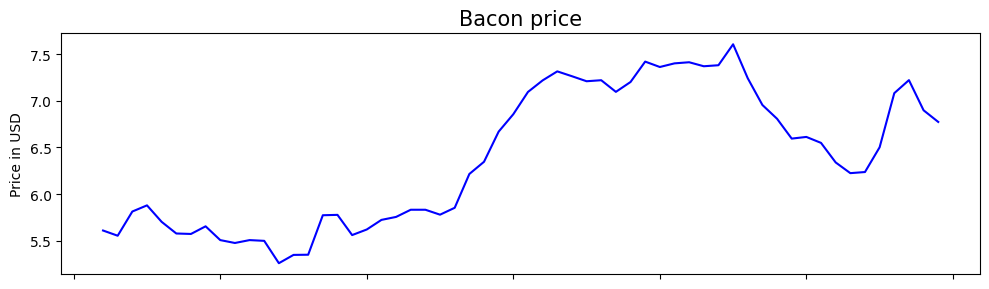

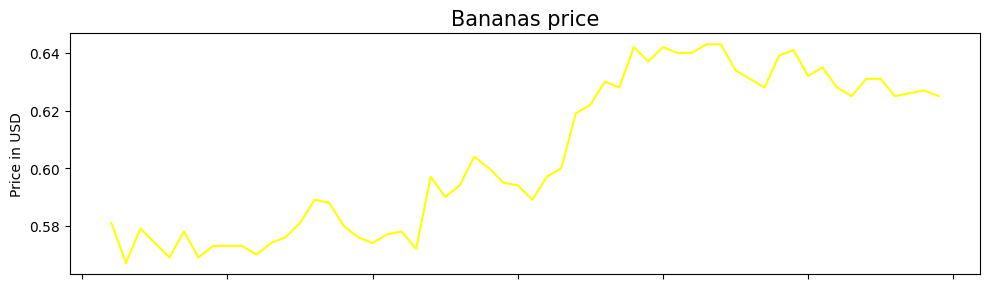

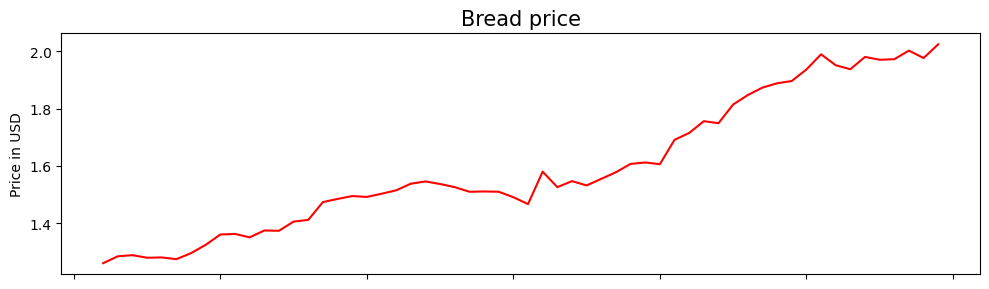

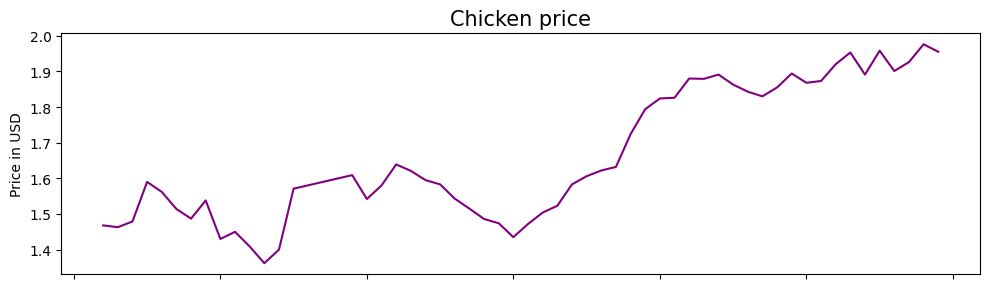

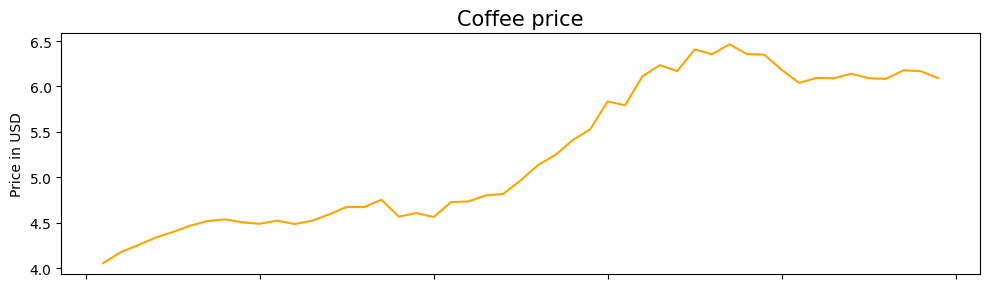

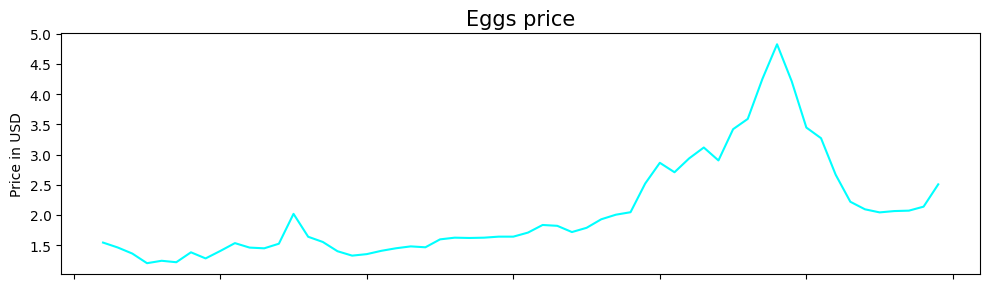

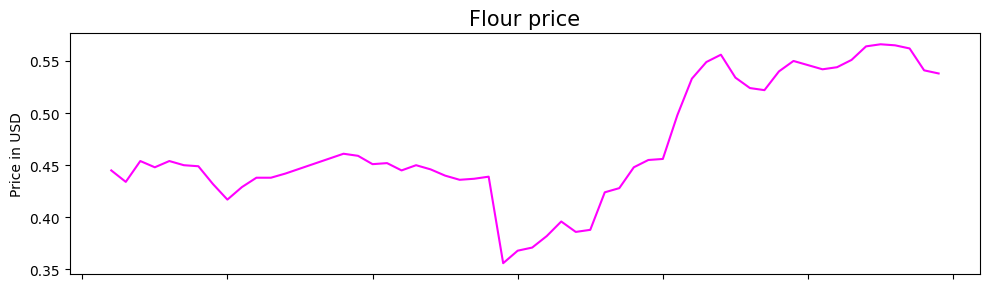

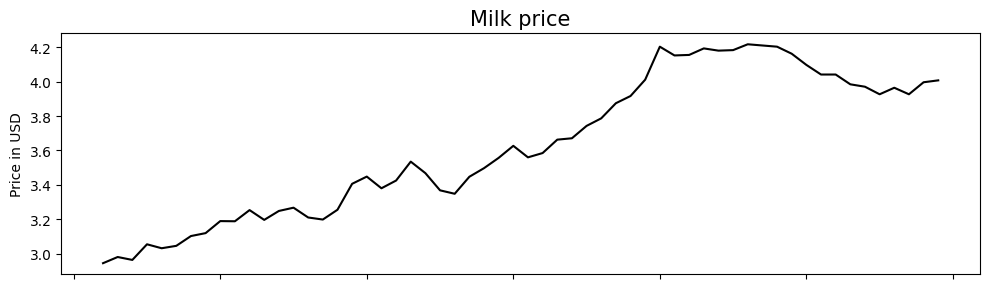

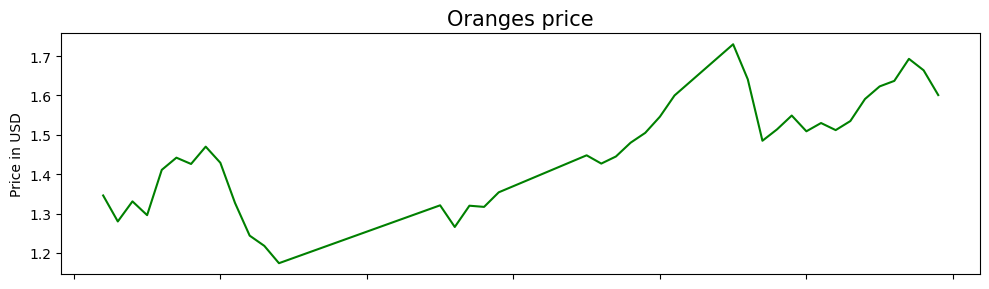

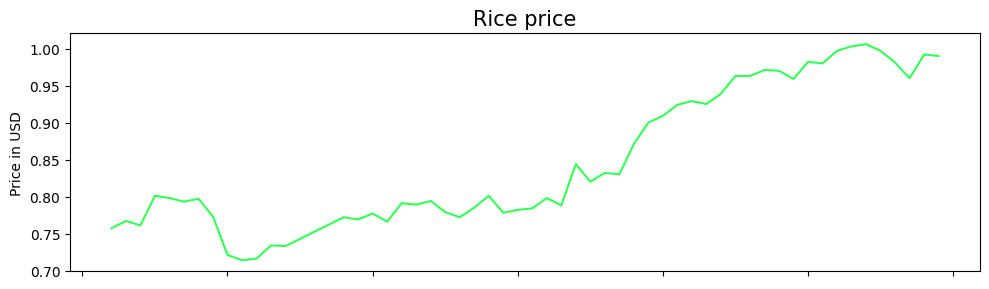

In [124]:
colors = ['blue', 'yellow', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black', 'green', '#33FF57']
for i in range(0, 10):
    show_price(data['Item'].unique()[i], colors[i])

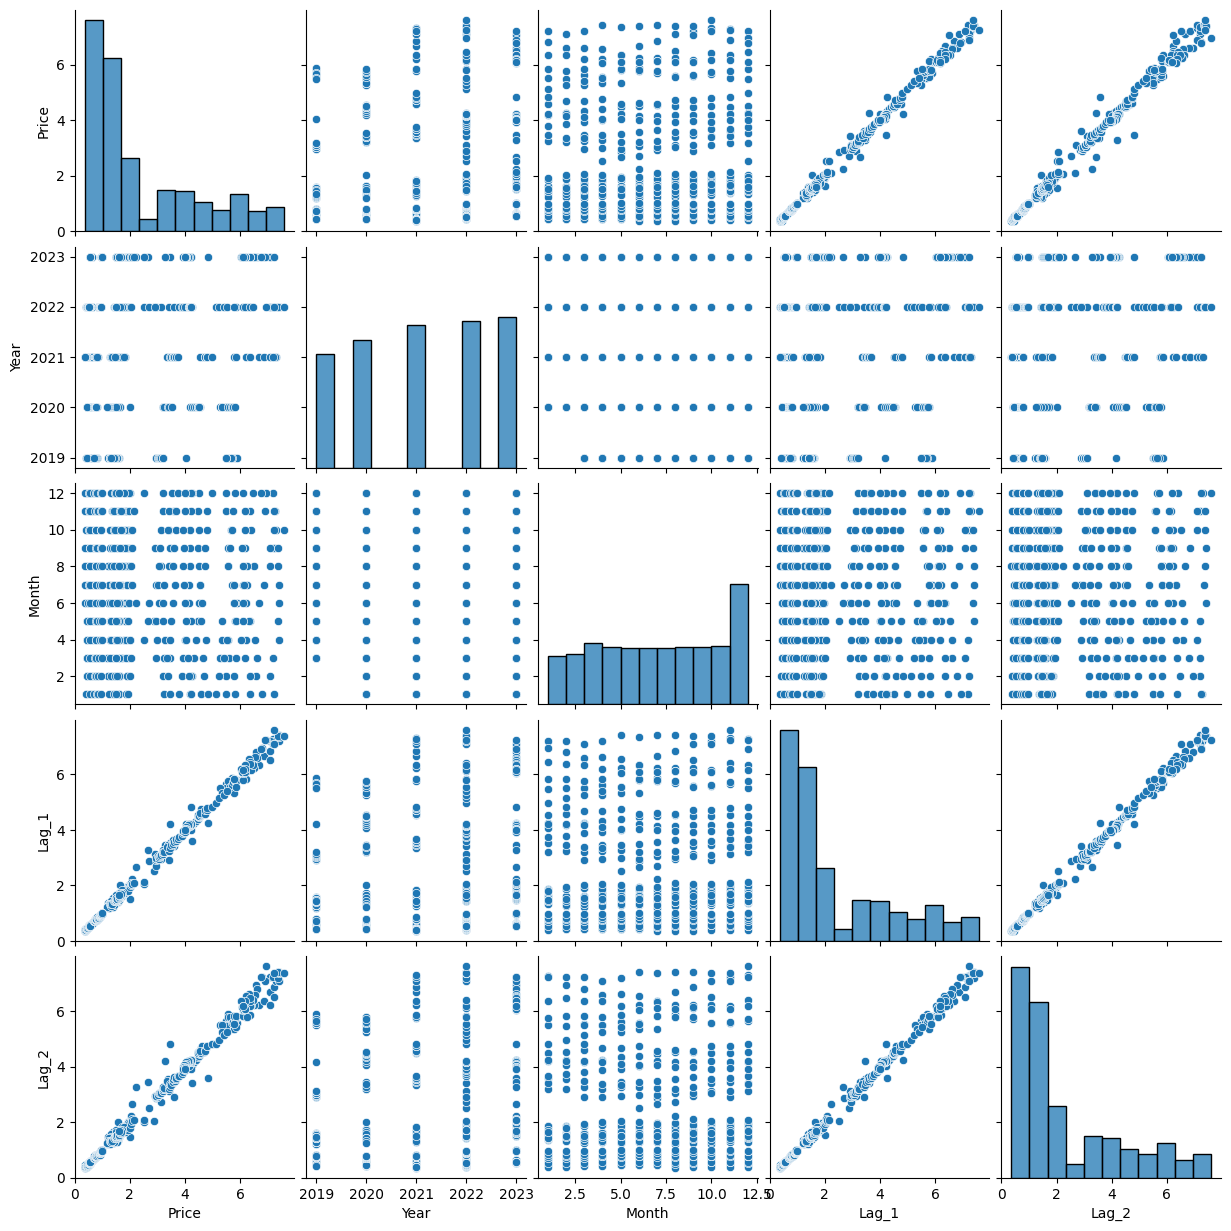

In [125]:
sns.pairplot(data)

## Encoding the categorical data

In [126]:
print("Unique valiues for the \"Item\" column: " + str(data['Item'].nunique()))
print("Unique valiues for the \"Rate\" column: " + str(data['Rate'].nunique()))

Unique valiues for the "Item" column: 10
Unique valiues for the "Rate" column: 3


Поради фактот што во датасетот имаме категориски податоци ќе мораме истите да ги енкодираме бидејќи не можеме да работиме со нив како такви. За енкодирање на податоците се одлучив да го користам методот "Label Encoding" поради фактот што имаме само 10 unique вредности за колоната "**Item**" и 3 за колоната "**Rate**" (проверката погоре). Label Encoding методот претставува метод на енкодирање на категориски податоци каде што за секоја вредност на податоците им задава нов index.
<br>
<br>
За колоната "**Item**", иако можеби станува збор за nominal categorical data се одлучив за користење на Label Encoder бидејќи нема да има проблем со тренирањето на моделот со оглед на тоа што би се тренирал модел за секој "**Item**" посебно.
<br>
<br>
Вредностите во колоната "Rate" пак претставуваат ordinal categorical data па за нив е и правилно да се искористи Label Encoder механизмот за енкодирање на категориските податоци.

In [127]:
le = LabelEncoder()
data['Item'] = le.fit_transform(data['Item'])
data['Rate'] = le.fit_transform(data['Rate'])
data

,Item,Rate,Price,Year,Month,Lag_1,Lag_2
2,0,2,5.608,2019,3,5.502,5.518
3,0,2,5.552,2019,4,5.608,5.502
4,0,2,5.812,2019,5,5.552,5.608
5,0,2,5.878,2019,6,5.812,5.552
6,0,2,5.701,2019,7,5.878,5.812
...,...,...,...,...,...,...,...
595,9,2,0.997,2023,8,1.006,1.003
596,9,2,0.981,2023,9,0.997,1.006
597,9,2,0.960,2023,10,0.981,0.997
598,9,2,0.992,2023,11,0.960,0.981


# Градење модели за предикција

Во овој момент започнуваме со поделба на множеството на test и train множества па за таа цел бидејќи би креирале модели за предикција за секој тип на храна посебно, направив функција каде што само потребно е да се подаде името на производот и датасетот.
<br><br>
За таргет колона e избрана колоната "**Price**" бидејќи целта на задачата е да предвидат цените на различните производи

In [128]:
def split_data_by_item(data, item_num):
    # Filter the DataFrame for the specified item
    df_item = data[data['Item'] == item_num].copy()

    # Select the features and target variable
    x = df_item[['Item', 'Rate', 'Year', 'Month', 'Lag_1', 'Lag_2']]
    y = df_item['Price']

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

    return X_train, X_test, Y_train, Y_test

За модели на предвидување ги одбрав следниве


*   Linear Regression <br> Поради фактот што
*   Random Forest Regression <br> Поради фактот што
*   XGBoost Regression <br> Поради фактот што



In [129]:
def linear_regression(X_train, X_test, Y_train, Y_test):
  model = LinearRegression()
  model.fit(X_train, Y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(Y_test, y_pred)
  r2 = r2_score(Y_test, y_pred)
  mae = mean_absolute_error(Y_test, y_pred)
  return mse, r2, mae

In [130]:
def random_forest_regressor(X_train, X_test, Y_train, Y_test):
  model = RandomForestRegressor(random_state=42)
  model.fit(X_train, Y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(Y_test, y_pred)
  r2 = r2_score(Y_test, y_pred)
  mae = mean_absolute_error(Y_test, y_pred)
  return mse, r2, mae

In [131]:
def xgb_regressor(X_train, X_test, Y_train, Y_test):
  model = xgb.XGBRegressor(random_state=42)
  model.fit(X_train, Y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(Y_test, y_pred)
  r2 = r2_score(Y_test, y_pred)
  mae = mean_absolute_error(Y_test, y_pred)
  return mse, r2, mae

Следнава функција служи за пресметување на успешноста на секој модел при работа со исти test и train множества по "**Item**" се со цел да биде поверодостојно истражувањето

In [132]:
def compare_model_metrics(ax, metric, values):
  models = ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression']

  # Create a bar chart
  ax.bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])

  # Add title and labels
  ax.set_title(metric + ' Values', fontsize=12)
  ax.set_xlabel('Models')
  ax.set_ylabel(metric)

  # Annotate the values on top of the bars
  for i, v in enumerate(values):
      ax.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom')

def plot_all_metrics(mse_values, rmse_values, r2_values, mae_values, item_num):
    fig, axs = plt.subplots(4, 1, figsize=(10, 15))
    fig.suptitle('Comparison of Models for Item: ' + str(item_num), fontsize=16)

    compare_model_metrics(axs[0], 'MSE', mse_values)
    compare_model_metrics(axs[1], 'RMSE', rmse_values)
    compare_model_metrics(axs[2], 'R2', r2_values)
    compare_model_metrics(axs[3], 'MAE', mae_values)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def training_models_by_item(data, item_num, plot_all):
  X_train, X_test, Y_train, Y_test = split_data_by_item(data, item_num)

  #Linear regression
  mse_linear, r2_linear, mae_linear= linear_regression(X_train, X_test, Y_train, Y_test)

  #Random forest regression
  mse_random_forest, r2_random_forest, mae_random_forest = random_forest_regressor(X_train, X_test, Y_train, Y_test)

  #XGBoost regression
  mse_xgb, r2_xgb, mae_xgb = xgb_regressor(X_train, X_test, Y_train, Y_test)

  # Comparison of the models
  mse_values = [mse_linear, mse_random_forest, mse_xgb]
  rmse_values = [np.sqrt(mse_linear), np.sqrt(mse_random_forest), np.sqrt(mse_xgb)]
  r2_values = [r2_linear, r2_random_forest, r2_xgb]
  mae_values = [mae_linear, mae_random_forest, mae_xgb]

  if(plot_all == True):
    plot_all_metrics(mse_values, rmse_values, r2_values, mae_values, item_num)
  return rmse_values

За споредба помеѓу успешноста на моделите ќе ја користиме метриката RMSE (Mean Squared Error) бидејќи обезбедува мерка на грешката во истите променливи како и таргет колоната.

In [133]:
# Initialize an empty dictionary to store RMSE values
rmse_dict = []

# Collect RMSE values for each item
for i in range(0, 10):
    rmse_values = training_models_by_item(data, i, False)  # Call function and get RMSE values
    rmse_dict.append({'Item ' + str(i) : {rmse_values[0], rmse_values[1], rmse_values[2]}})

In [137]:
models = ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression']

df_data = {f'Item {i}': [] for i in range(len(rmse_dict))}

for i, item_data in enumerate(rmse_dict):
    item_name, values = list(item_data.items())[0]
    sorted_values = sorted(values)

    for j, model in enumerate(models):
        if j >= len(df_data[item_name]):
            df_data[item_name].append(sorted_values[j])
        else:
            df_data[item_name][j] = sorted_values[j]

df = pd.DataFrame(df_data, index=models)
df['Average RMSE'] = df.mean(axis=1)

df

,Item 0,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Average RMSE
Linear Regression,0.186015,0.005355,0.023567,0.064215,0.092598,0.228344,0.006869,0.066222,0.061673,0.026040,0.076090
Random Forest Regression,0.196309,0.007098,0.026824,0.068158,0.126720,0.267172,0.010461,0.066963,0.064166,0.026507,0.086038
XGBoost Regression,0.296032,0.007601,0.037103,0.085556,0.135450,0.405619,0.018426,0.077840,0.065119,0.030944,0.115969
